This file contains the program used to hyperparameter tune our hyperparameters with pytorch:
Learning Rate
Number of Epochs
Batch Size


In [1]:
from functions_text_model import *
import os

In [2]:

from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import json
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.utils.data import random_split
from sklearn.model_selection import ParameterGrid


# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# PyTorch Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm
# Create the DataLoader
# Load the data from the JSON file
with open('sarcasm_data.json') as f:
    data = json.load(f)

# Convert the data to a list of dictionaries
data = list(data.values())

dataset = SarcasmDataset(data)

/Users/sinarollin/opt/anaconda3/envs/DLPROJ/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define the hyperparameters to tune
param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'num_epochs': [5, 10, 15],
    'batch_size': [8, 16, 32, 64]
}

# Set device
#device = torch.device("cpu")

# Create a parameter grid
grid = ParameterGrid(param_grid)

# For each combination of hyperparameters
for params in grid:
    # Create a new model
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False,
    )
    model.bert.parameters.requires_grad = False

    #model.to(device)

    # Create a new optimizer with the current learning rate
    optimizer = AdamW(model.parameters(), lr=params['lr'])
    # Create the optimizer  
    criterion = nn.CrossEntropyLoss()

    metrics = {'ACC': acc, 'F1-weighted': f1}
    # Define the size of the training set and the test set
    train_size = int(0.8 * len(dataset))  # 80% of the data for training
    test_size = len(dataset) - train_size  # 20% of the data for testing

    # Split the dataset
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create the DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'])
    test_dataloader = DataLoader(test_dataset, batch_size=params['batch_size'])


    # Train and evaluate the model for the current number of epochs
    for epoch in range(params['num_epochs']):
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_dataloader, device)
        eval_loss, eval_metrics = evaluate(model, criterion, metrics, test_dataloader, device)

    # Print the results
    print(f"lr: {params['lr']}, batch_size: {params['batch_size']}, num_epochs: {params['num_epochs']}, eval_loss: {eval_loss}, eval_metrics: {eval_metrics}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


: 

In [9]:
# Define the hyperparameters to tune
param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'num_epochs': [5],
    'batch_size': [8, 16, 32, 64]
}


# Create a parameter grid
grid = ParameterGrid(param_grid)

# Initialize a list to store the results
results = []

# For each combination of hyperparameters
for params in grid:
    # Create a new model
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False,
    )

    # Set device
    device = torch.device("cpu")
    model.to(device)

    # Create a new optimizer with the current learning rate
    # FINE BUT NEED TO FOCUS ON LAYER
    optimizer = AdamW(model.classifier.parameters(), lr=params['lr'])
    # Create the optimizer  
    criterion = nn.CrossEntropyLoss()

    metrics = {'ACC': acc, 'F1-weighted': f1}
    # Define the size of the training set and the test set
    train_size = int(0.8 * len(dataset))  # 80% of the data for training
    test_size = len(dataset) - train_size  # 20% of the data for testing

    # Split the dataset
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create the DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'])
    test_dataloader = DataLoader(test_dataset, batch_size=params['batch_size'])


    # Train and evaluate the model for the current number of epochs
    for epoch in range(params['num_epochs']):
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_dataloader, device)
        eval_loss, eval_metrics = evaluate(model, criterion, metrics, test_dataloader, device)

    # Store the results
    results.append({
        'lr': params['lr'],
        'batch_size': params['batch_size'],
        'num_epochs': params['num_epochs'],
        'eval_loss': eval_loss,
        'eval_metrics': eval_metrics
    })

# Save the results to a JSON file
with open('results.json', 'w') as f:
    json.dump(results, f)

print(results)

train Loss: 0.6928,  ACC: 0.5215, F1-weighted: 0.4583


100%|██████████| 3/3 [00:13<00:00,  4.47s/it]


eval Loss: 0.6984,  ACC: 0.4844, F1-weighted: 0.3486
[{'lr': 0.001, 'batch_size': 8, 'num_epochs': 5, 'eval_loss': 0.6320563554763794, 'eval_metrics': {'ACC': 0.6319444444444444, 'F1-weighted': 0.49410589410589423}}, {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 5, 'eval_loss': 0.6813187963432736, 'eval_metrics': {'ACC': 0.6041666666666666, 'F1-weighted': 0.5322923989590657}}, {'lr': 1e-05, 'batch_size': 8, 'num_epochs': 5, 'eval_loss': 0.6862524151802063, 'eval_metrics': {'ACC': 0.5486111111111112, 'F1-weighted': 0.48931284764618105}}, {'lr': 0.001, 'batch_size': 16, 'num_epochs': 5, 'eval_loss': 0.7095533344480727, 'eval_metrics': {'ACC': 0.5416666666666666, 'F1-weighted': 0.5298845862313354}}, {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 5, 'eval_loss': 0.6883872614966499, 'eval_metrics': {'ACC': 0.5388888888888889, 'F1-weighted': 0.44173358847271893}}, {'lr': 1e-05, 'batch_size': 16, 'num_epochs': 5, 'eval_loss': 0.7074771987067329, 'eval_metrics': {'ACC': 0.45694444444444443, 'F

In [5]:
model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False,
    )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model.parameters()




<generator object Module.parameters at 0x12f2b3d80>

In [ ]:
lr = 0.0001
batchsize = 8
epochs = 5

train Loss: 0.0900,  ACC: 0.9783, F1-weighted: 0.9735


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


eval Loss: 0.7990,  ACC: 0.7083, F1-weighted: 0.6801


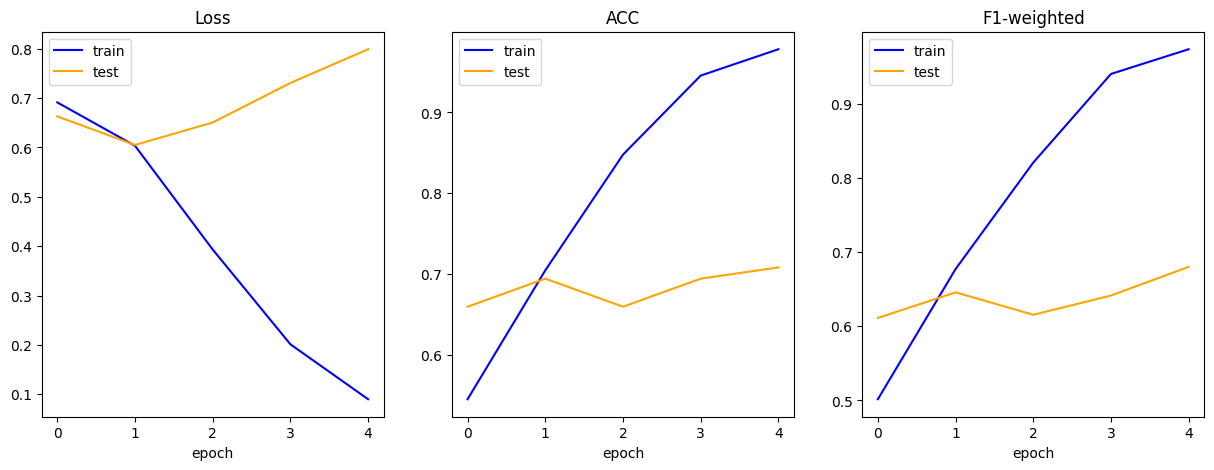

Model trained and saved!


In [7]:
torch.manual_seed(314159)

# Load BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the base BERT model
    num_labels = 2, # Binary classification (sarcasm or not)
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Load the BERT tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#HYPEPARAMETERs TO TUNE
learning_rate = 0.001
N_EPOCHS = 5
batchsize = 8

# Define the size of the training set and the test set
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batchsize)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize)

# Set device
device = torch.device("cpu")

# Move the model to the CPU
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()


metrics = {'ACC': acc, 'F1-weighted': f1}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_augmented_set.pth')

print('Model trained and saved!')

In [ ]:
torch.manual_seed(314159)

# Load BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the base BERT model
    num_labels = 2, # Binary classification (sarcasm or not)
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Load the BERT tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#HYPEPARAMETERs TO TUNE
learning_rate = 0.001
N_EPOCHS = 5
batchsize = 8

# Define the size of the training set and the test set
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batchsize)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize)

# Set device
device = torch.device("cpu")

# Move the model to the CPU
model.to(device)

# Create the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()


metrics = {'ACC': acc, 'F1-weighted': f1}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_augmented_set.pth')

print('Model trained and saved!')